In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import warnings
from ptolemy import normed
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Bx, pot, definition
zpos, bx = np.loadtxt('lngs_3perm_asym_Bx.txt').T

bn, bmax = normed(bx)

print (bmax)


1.2595


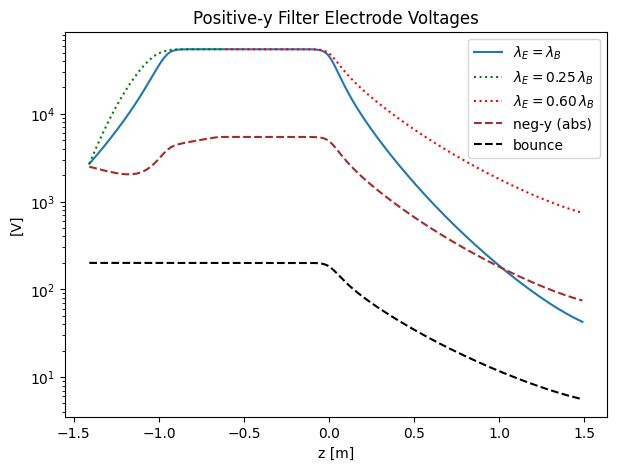

146
Sub SetBn_adj()
	bn_adj(  0    )    =  0.049460897181421194
	bn_adj(  1    )    =  0.06106352180851241
	bn_adj(  2    )    =  0.07495727333737724
	bn_adj(  3    )    =  0.0914641086984564
	bn_adj(  4    )    =  0.11091993153436168
	bn_adj(  5    )    =  0.13365450148770602
	bn_adj(  6    )    =  0.16000631631467016
	bn_adj(  7    )    =  0.19024694238081347
	bn_adj(  8    )    =  0.22464639615987894
	bn_adj(  9    )    =  0.2633853113622894
	bn_adj(  10    )    =  0.3065772986356792
	bn_adj(  11    )    =  0.3541911297205749
	bn_adj(  12    )    =  0.40611539204748637
	bn_adj(  13    )    =  0.4620320627764421
	bn_adj(  14    )    =  0.5214393285899699
	bn_adj(  15    )    =  0.5835764590455962
	bn_adj(  16    )    =  0.6473898801435173
	bn_adj(  17    )    =  0.7114537141552071
	bn_adj(  18    )    =  0.7739407211177982
	bn_adj(  19    )    =  0.832657189181192
	bn_adj(  20    )    =  0.8851690630123321
	bn_adj(  21    )    =  0.9169960656827989
	bn_adj(  22    )    =  0.946069950

In [4]:
# Bx and Bn, plot

# Map z pos to z indices, filter electrodes
eth = 0.001

n_accel = 146
n_ramp = 20
n_ramp_neg = 38
n_fstart = 50
n_fstepdown = n_accel-60

pd_z 		= -1.521275
pd_widthf	= 0.10
pd_widthb	= 0.03
pd_zstart   = pd_z-pd_widthb
pd_zend_injection = pd_z+pd_widthf

fe_width 	= 0.016
fe_gap 		= 0.004
fe_step 	= fe_width +fe_gap

fe_x       	= 0.055
fe_y 		= 0.015
fe_z_start 	= pd_z+pd_widthf+n_accel*fe_step+fe_gap+fe_width/2

pdv5 = 0
pdv4 = 100
pdv3 = 200
pdv2 = 800
pdv1 = 1500

c = 2500
negyt = 0

a_indices = []
for z in range(n_accel):
    zposa = pd_zend_injection +fe_gap +fe_width/2 +z*fe_step 
    zindex = int(zposa*1000) +1700
    # print (zindex)
    a_indices.append(zindex)

j = 0
zpos_accel_arr = []
bn_accel_arr = []
i_accel_arr = []
bn_adj_arr = []
bn_bounce_adj_arr = []
negy_arr = []

for i,bnval in enumerate(bn):
    if i in a_indices:
        zpos_accel_arr.append(zpos[i])
        bn_accel_arr.append(bnval)
        i_accel_arr.append(j)
        j+=1

zpos_accel = np.array(zpos_accel_arr)
bn_accel = np.array(bn_accel_arr)
i_accel = np.array(i_accel_arr)

offset = 0.10

target_lambda = 0.25
post_lambda = 0.60
final_lambda = 0.60

btarget_lambda = 0.25
bpost_lambda = 0.50
bfinal_lambda = 0.95

vscale5   = (pdv5+c)/bn_accel[0]
vscale4   = (pdv4+c)/bn_accel[0]
vscale3   = (pdv3+c)/bn_accel[0]

for z,bn_acc in enumerate(bn_accel):
    
    #injection region n_ramp=20
    if z<n_ramp: 
        bn_adj_arr.append(bn_acc**(1+(target_lambda-1)*z/n_ramp))
        
    # uniform region
    elif z>=n_ramp and z<n_fstart: 
        bn_adj_arr.append(bn_acc**target_lambda)
    
    #filter region n_fstart=50
    elif z>=n_fstart and z<n_fstepdown: 
        bn_adj_arr.append(bn_acc**post_lambda)

    #stepdown region n_fstepdown=86
    else:
        bn_adj_arr.append(bn_acc**(post_lambda+(final_lambda-post_lambda)*(z-n_fstepdown)/(n_accel-n_fstepdown)))

for z,bn_acc in enumerate(bn_accel):
    #injection region n_ramp_neg=38
    if z<n_ramp_neg: 
        negy_arr.append((pdv5-c)+ ( (negyt-offset*vscale3*bn_acc)-(pdv5-c) )*(z/n_ramp_neg))
        
    # uniform region
    elif z>=n_ramp_neg and z<n_fstart: 
        negy_arr.append(-offset*vscale3*bn_acc)
    
    #filter region n_fstart=50
    elif z>=n_fstart and z<n_fstepdown: 
        negy_arr.append(-offset*vscale3*bn_acc**post_lambda)

    #stepdown region n_fstepdown=86
    else:
        negy_arr.append(-offset*vscale3*bn_adj_arr[z])

for z,bn_acc in enumerate(bn_accel):
    #injection region
    if z<n_ramp_neg: 
        bn_bounce_adj_arr.append(1)
        
    else:
        bn_bounce_adj_arr.append(bn_acc**0.50)

bn_adj = np.array(bn_adj_arr)
bn_bounce_adj = np.array(bn_bounce_adj_arr)
negy = np.array(negy_arr)

fig, ax = plt.subplots(1,1, figsize=(7,5))

# ax.plot(zpos_accel, 200*bn_accel**0.5, label='bounce')
ax.plot(zpos_accel, vscale3*bn_accel, label=r'$\lambda_E=\lambda_B$', linestyle='solid')
ax.plot(zpos_accel[:40], vscale3*bn_adj[:40], label=r'$\lambda_E=0.25\,\lambda_B$', color='green', linestyle='dotted')
ax.plot(zpos_accel[40:], vscale3*bn_adj[40:], label=r'$\lambda_E=0.60\,\lambda_B$', color='red', linestyle='dotted')
ax.plot(zpos_accel, abs(negy), label=r'neg-y (abs)', color='brown', linestyle='dashed')
ax.plot(zpos_accel, 200*bn_bounce_adj, label=r'bounce', color='black', linestyle='dashed')

ax.set_title('Positive-y Filter Electrode Voltages')
ax.set_xlabel('z [m]')
ax.set_ylabel('[V]')
ax.set_yscale('log')
ax.legend()
plt.show()

print(len(zpos_accel))

# SetBn_adj()
print('Sub SetBn_adj()')
for i,val in enumerate(bn_adj):
    print(f'\tbn_adj(  {i}    )    =  {val}')
print('End Sub')

# print('Sub SetBn_bounce_adj()')
# for i,val in enumerate(bn_bounce_adj):
#     print(f'\tbn_bounce_adj(  {i}    )    =  {val}')
# print('End Sub')

In [5]:
# MakeParaDrainArcElectrodes(), print function
from math import sqrt, tan, sin, cos, radians

s = 5.84/100

a = s*4.25
b = s*3.85
c = sqrt(abs(a**2-b**2))

eclipz = -1.302

m = 1

facenum = 11
facenum_1 = 11

#from bottom up

angles = [ (15+m,30-m), (30+m,45-m), (45+m,60-m), (60+m,90-m) ]

potentials = [ 15000, 12000, 8000, 5000 ]

print('Sub MakeParaDrainArcElectrodes()')
for ((th1, th2),pot) in zip(angles, potentials):

    y1 = (a*b)/sqrt(b**2+(a**2)*tan((radians(th1)))**2)
    x1 = y1*tan(radians(th1))
    r1 = sqrt(x1**2+y1**2)

    z1i = (r1-0.04)*sin(radians(th1))
    x1i = (r1-0.04)*cos(radians(th1))
                        
    z1o = (r1+0.03)*sin(radians(th1))
    x1o = (r1+0.03)*cos(radians(th1))

    y2 = (a*b)/sqrt(b**2+(a**2)*tan((radians(th2)))**2)
    x2 = y2*tan(radians(th2))
    r2 = sqrt(x2**2+y2**2)

    z2i = (r2-0.04)*sin(radians(th2))
    x2i = (r2-0.04)*cos(radians(th2))
                        
    z2o = (r2+0.03)*sin(radians(th2))
    x2o = (r2+0.03)*cos(radians(th2))

    print(f'\tWith Polygon3D')
    print(f'\t\t.Reset')
    print(f'\t\t.Name \"pd_{th1}_{th2}_outline\"')
    print(f'\t\t.Curve \"paradrain_curve\"')
    print(f'\t\t.Point {-x1i:.3f}, fe_y, {eclipz:.3f}-{z1i:.3f}  ')
    print(f'\t\t.Point {-x1o:.3f}, fe_y, {eclipz:.3f}-{z1o:.3f}  ')
    print(f'\t\t.Point {-x2o:.3f}, fe_y, {eclipz:.3f}-{z2o:.3f}  ')
    print(f'\t\t.Point {-x2i:.3f}, fe_y, {eclipz:.3f}-{z2i:.3f}  ')
    print(f'\t\t.Point {-x1i:.3f}, fe_y, {eclipz:.3f}-{z1i:.3f}  ')
    print(f'\t\t.Create')
    print(f'\tEnd With')
    print(f'\tWith Polygon3D')
    print(f'\t\t.Reset')
    print(f'\t\t.Name \"pd_{th1}_{th2}_profile\"')
    print(f'\t\t.Curve \"paradrain_curve\"')
    print(f'\t\t.Point {-x1i:.3f}, fe_y, {eclipz:.3f}-{z1i:.3f}  ')
    print(f'\t\t.Point {-x1i:.3f}, fe_y+eth, {eclipz:.3f}-{z1i:.3f}  ')
    print(f'\t\t.Create')
    print(f'\tEnd With')                  
    print(f'\tMakeSweepCurve(\"pd_{th1}_{th2}\", \"paradrain_electrodes\", \"PEC\", _')
    print(f'\t\t\"paradrain_curve:pd_{th1}_{th2}_outline\", \"paradrain_curve:pd_{th1}_{th2}_profile\" _')
    print(f'\t)')
    print(f'\tMirrorCopyY(\"paradrain_electrodes:pd_{th1}_{th2}\")')
    print(f'\tMakeBrick(\"pd_cutout\", \"paradrain_electrodes\", \"Vacuum\", -fe_x, fe_x, -(fe_y+eth), (fe_y+eth), {eclipz:.3f}-0.5, {eclipz:.3f})')
    print(f'\tSolid.Subtract \"paradrain_electrodes:pd_{th1}_{th2}\", \"paradrain_electrodes:pd_cutout\"')
    print(f'\tMakeBrick(\"pd_cutout\", \"paradrain_electrodes\", \"Vacuum\", -fe_x, fe_x, -(fe_y+eth), (fe_y+eth), {eclipz:.3f}-0.5, {eclipz:.3f})')
    print(f'\tSolid.Subtract \"paradrain_electrodes:pd_{th1}_{th2}_1\", \"paradrain_electrodes:pd_cutout\"')
    print(f'\tMakePotential( \"pd_{th1}_{th2}\", {pot}, _')
    print(f'\t\t\"paradrain_electrodes:pd_{th1}_{th2}\", \"{facenum}\" _')
    print(f'\t)')
    print(f'\tMakePotential( \"pd_{th1}_{th2}_1\", {pot}, _')
    print(f'\t\t\"paradrain_electrodes:pd_{th1}_{th2}_1\", \"{facenum_1}\" _')
    print(f'\t)')
print('End Sub')


Sub MakeParaDrainArcElectrodes()
	With Polygon3D
		.Reset
		.Name "pd_16_29_outline"
		.Curve "paradrain_curve"
		.Point -0.198, fe_y, -1.302-0.057  
		.Point -0.265, fe_y, -1.302-0.076  
		.Point -0.238, fe_y, -1.302-0.132  
		.Point -0.177, fe_y, -1.302-0.098  
		.Point -0.198, fe_y, -1.302-0.057  
		.Create
	End With
	With Polygon3D
		.Reset
		.Name "pd_16_29_profile"
		.Curve "paradrain_curve"
		.Point -0.198, fe_y, -1.302-0.057  
		.Point -0.198, fe_y+eth, -1.302-0.057  
		.Create
	End With
	MakeSweepCurve("pd_16_29", "paradrain_electrodes", "PEC", _
		"paradrain_curve:pd_16_29_outline", "paradrain_curve:pd_16_29_profile" _
	)
	MirrorCopyY("paradrain_electrodes:pd_16_29")
	MakeBrick("pd_cutout", "paradrain_electrodes", "Vacuum", -fe_x, fe_x, -(fe_y+eth), (fe_y+eth), -1.302-0.5, -1.302)
	Solid.Subtract "paradrain_electrodes:pd_16_29", "paradrain_electrodes:pd_cutout"
	MakeBrick("pd_cutout", "paradrain_electrodes", "Vacuum", -fe_x, fe_x, -(fe_y+eth), (fe_y+eth), -1.302-0.5, -1.302)


In [6]:
# SetBn_accel(), accel electrodes
print('Sub SetBn_accel()')
j = 0
for i,bnval in enumerate(bn):
    if i in a_indices:
        print(f'\tbn_accel(  {j}    )    =  {bnval} \t\' z={zpos[i]} ')
        j+=1
print('End Sub')

Sub SetBn_accel()
	bn_accel(  0    )    =  0.049460897181421194 	' z=-1.409 
	bn_accel(  1    )    =  0.054761413259229855 	' z=-1.389 
	bn_accel(  2    )    =  0.06075506153235411 	' z=-1.369 
	bn_accel(  3    )    =  0.06754267566494641 	' z=-1.349 
	bn_accel(  4    )    =  0.07524573243350535 	' z=-1.329 
	bn_accel(  5    )    =  0.08400158793171894 	' z=-1.309 
	bn_accel(  6    )    =  0.09398967844382691 	' z=-1.289 
	bn_accel(  7    )    =  0.10539102818578801 	' z=-1.269 
	bn_accel(  8    )    =  0.118459706232632 	' z=-1.249 
	bn_accel(  9    )    =  0.13348154029376735 	' z=-1.229 
	bn_accel(  10    )    =  0.15082175466454942 	' z=-1.209 
	bn_accel(  11    )    =  0.1709011512504962 	' z=-1.189 
	bn_accel(  12    )    =  0.19429138547042477 	' z=-1.169 
	bn_accel(  13    )    =  0.22166732830488287 	' z=-1.149 
	bn_accel(  14    )    =  0.25388646288209604 	' z=-1.129 
	bn_accel(  15    )    =  0.2919888844779674 	' z=-1.109 
	bn_accel(  16    )    =  0.33722111949186184 	' z